# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [2]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IRAHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IRA']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

In [3]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

In [4]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

In [5]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

c:\users\hp-z440\anaconda projects\svi-trading-tools\tools\utils.py:338: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker', 'date']).mean().fillna(0)


In [6]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

In [7]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

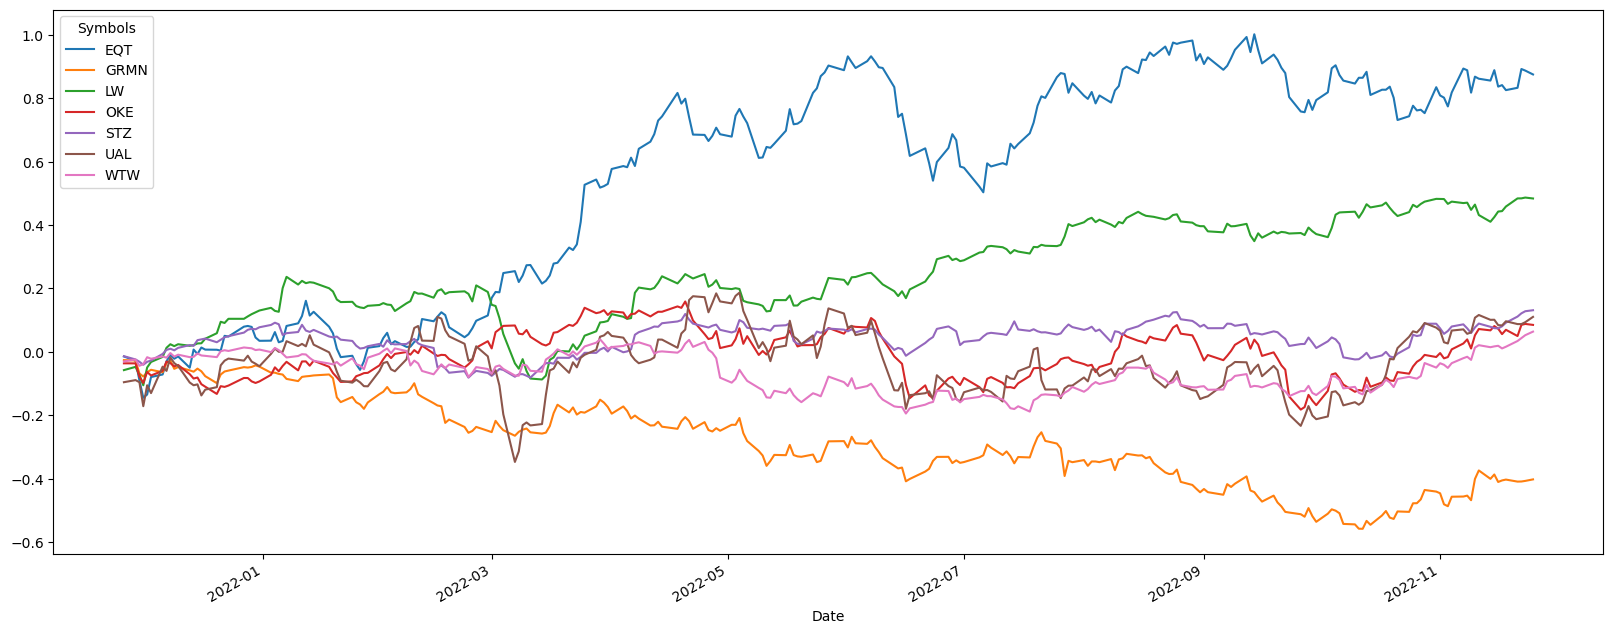

In [8]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [9]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

In [17]:
td_ameritrade = amc.AmeritradeRest()
td_ameritrade.authenticate()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

2022-11-28 09:43:09,375|WDM|INFO|====== WebDriver manager ======
2022-11-28 09:43:10,247|WDM|INFO|Get LATEST chromedriver version for google-chrome 107.0.5304
2022-11-28 09:43:11,178|WDM|INFO|About to download new driver from https://chromedriver.storage.googleapis.com/107.0.5304.62/chromedriver_win32.zip


[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.46M/6.46M [00:00<00:00, 22.3MB/s]


2022-11-28 09:43:12,426|WDM|INFO|Driver has been saved in cache [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304]


,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,910047109,UAL,"United Airlines Holdings, Inc. - Common Stock",NASDAQ,EQUITY,53.115,30.5400,0.00,0.00,,...,0.00000,0.0,0.0,0.0,0.000,,1.33715,4824850.0,4824845.0,194452980.0
1,682680103,OKE,"ONEOK, Inc. Common Stock",NYSE,EQUITY,75.070,50.5000,3.74,5.72,2022-10-31 00:00:00.000,...,71.99105,0.0,0.0,0.0,0.935,2022-11-14 00:00:00.000,1.67064,2288660.0,2288660.0,54093180.0
2,21036P108,STZ,"Constellation Brands, Inc. Common Stock",NYSE,EQUITY,261.525,207.5916,3.20,1.24,2022-11-03 00:00:00.000,...,12.04015,0.0,0.0,0.0,0.800,2022-11-18 00:00:00.000,0.98790,1012630.0,1012633.0,20957580.0
3,26884L109,EQT,EQT Corporation Common Stock,NYSE,EQUITY,51.970,17.9500,0.60,1.39,2022-11-08 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.150,2022-12-01 00:00:00.000,1.16831,5108480.0,5108479.0,184605710.0
4,513272104,LW,"Lamb Weston Holdings, Inc. Common Stock",NYSE,EQUITY,88.040,49.7100,0.98,1.14,2022-11-03 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.245,2022-12-02 00:00:00.000,0.52923,1494360.0,1494362.0,34543290.0
5,G96629103,WTW,Willis Towers Watson Public Limited Company - ...,NASDAQ,EQUITY,244.730,187.8900,3.28,1.34,2022-09-29 00:00:00.000,...,8.02709,0.0,0.0,0.0,0.820,2022-10-17 00:00:00.000,0.77005,647810.0,647809.0,12928810.0
6,H2906T109,GRMN,Garmin Ltd. Common Stock (Switzerland),NYSE,EQUITY,140.930,76.3700,2.92,3.21,2022-12-14 00:00:00.000,...,11.85881,0.0,0.0,0.0,0.730,2022-12-30 00:00:00.000,0.97519,756220.0,756221.0,21442890.0


Tickers:   0%|          | 0/7 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/7 [00:00<?, ?News Table Items/s]

C:\Users\HP-Z440\AppData\Local\Temp\ipykernel_9952\1254735451.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


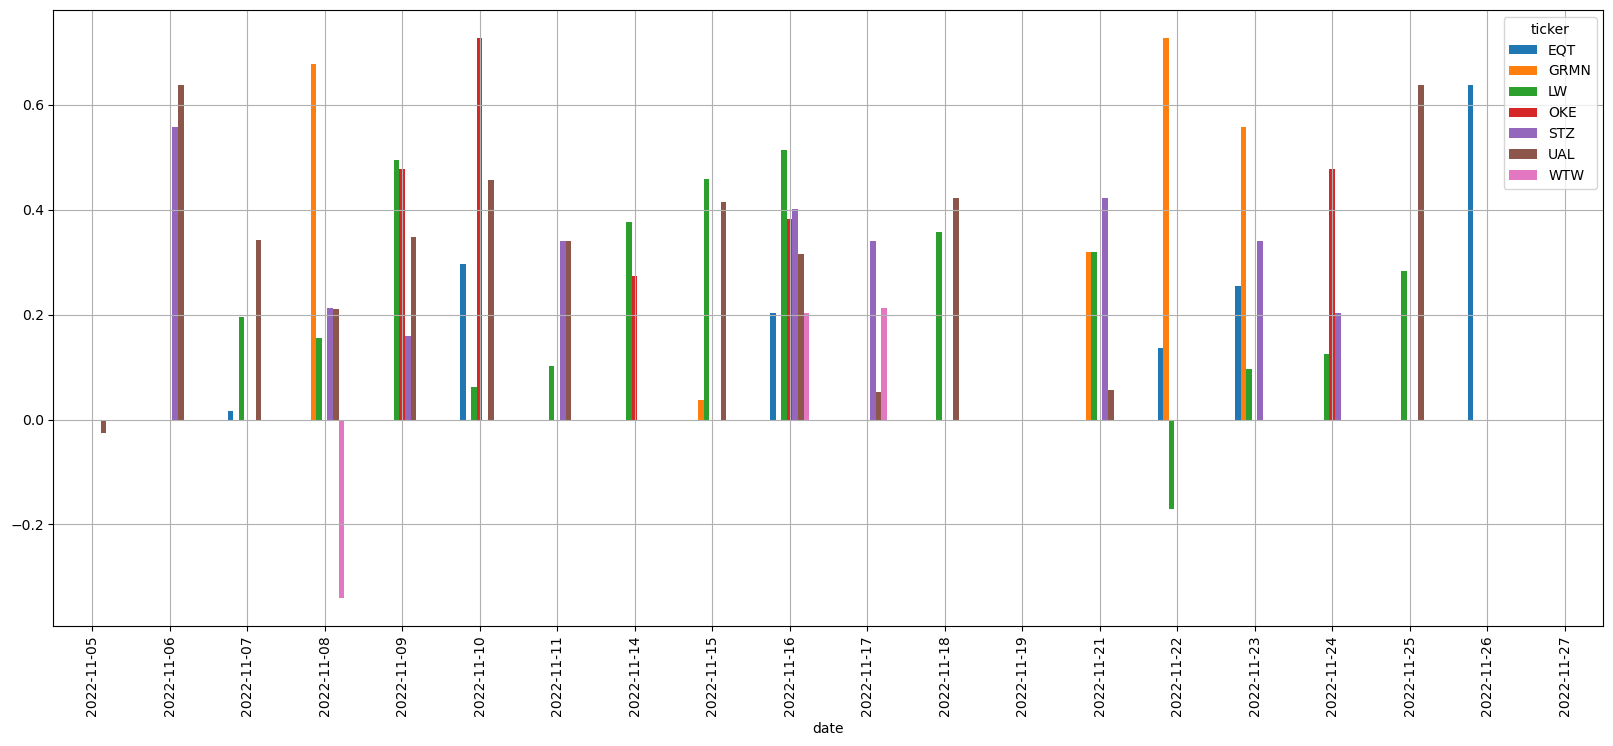

In [12]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [13]:
if len(td_ameritrade.authorization) == 0:
    logger.error(f'Error: No authorization data: {td_ameritrade.authorization}')
    raise Exeption
else:
    logger.info('You have authorization')

In [14]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 SCHF              0.0      35.56279             0.0   
         VTIP              0.0      52.14316             0.0   
         VGK               0.0      59.10313             0.0   
         FNCL              0.0      40.44691             0.0   
         CAT               0.0     229.24455             0.0   
         FSTA              0.0      42.61006             0.0   
         SCHM              0.0      77.86802             0.0   
         VWO               0.0      50.42377             0.0   
         ETR               0.0     111.98500             0.0   
         GWW               0.0     598.87167             0.0   
         VBR               0.0     169.07886             0.0   
         HSY               0.0     225.99000             0.0   
         PCAR              0.0     103.83270             0.0   
         VTR               0.0      43.70227             0.0   
         WAB               0.0      98.48513             0.0   
         FGPHF             0.0       0.12293             0.0   
         WKHS              0.0      12.43990             0.0   
         EEENF             0.0       0.04960             0.0   
         VOO               0.0     370.43264             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 SCHF                     0.0                             0.0   
         VTIP                     0.0                             0.0   
         VGK                      0.0                             0.0   
         FNCL                     0.0                             0.0   
         CAT                      0.0                             0.0   
         FSTA                     0.0                             0.0   
         SCHM                     0.0                             0.0   
         VWO                      0.0                             0.0   
         ETR                      0.0                             0.0   
         GWW                      0.0                             0.0   
         VBR                      0.0                             0.0   
         HSY                      0.0                             0.0   
         PCAR                     0.0                             0.0   
         VTR                      0.0                             0.0   
         WAB                      0.0                             0.0   
         FGPHF                    0.0                             0.0   
         WKHS                     0.0                             0.0   
         EEENF                    0.0                             0.0   
         VOO                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 SCHF          60.707               60.707                   0.0   
         VTIP          71.973               71.973                   0.0   
         VGK           35.925               35.925                   0.0   
         FNCL          13.224               13.224                   0.0   
         CAT           11.000               11.000                   0.0   
         FSTA           5.088                5.088                   0.0   
         SCHM          20.291               20.291                   0.0   
         VWO           15.362               15.362                   0.0   
         ETR           34.000               34.000                   0.0   
         GWW            6.000                6.000                   0.0   
         VBR            3.094                3.094                   0.0   
         HSY           17.000               17.000                   0.0   
         PCAR          37.000               37.000                   0.0  

In [15]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 CAT               0.0     229.24455             0.0   
         ETR               0.0     111.98500             0.0   
         GWW               0.0     598.87167             0.0   
         HSY               0.0     225.99000             0.0   
         PCAR              0.0     103.83270             0.0   
         VTR               0.0      43.70227             0.0   
         WAB               0.0      98.48513             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 CAT                      0.0                             0.0   
         ETR                      0.0                             0.0   
         GWW                      0.0                             0.0   
         HSY                      0.0                             0.0   
         PCAR                     0.0                             0.0   
         VTR                      0.0                             0.0   
         WAB                      0.0                             0.0   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 CAT             11.0                 11.0                   0.0   
         ETR             34.0                 34.0                   0.0   
         GWW              6.0                  6.0                   0.0   
         HSY             17.0                 17.0                   0.0   
         PCAR            37.0                 37.0                   0.0   
         VTR             88.0                 88.0                   0.0   
         WAB             39.0                 39.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---5311 CAT         2592.70                 2592.70   
         ETR         3867.50                 3867.50   
         GWW         3625.50                 3625.50   
         HSY         3973.92                 3973.92   
         PCAR        3886.11                 3886.11   
         VTR         4003.12                 4003.12   
         WAB         3934.32                 3934.32   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---5311 CAT                            11.0    EQUITY  149123101           0   
         ETR                            34.0    EQUITY  29364G103           0   
         GWW                             6.0    EQUITY  384802104           0   
         HSY                            17.0    EQUITY  427866108           0   
         PCAR                           37.0    EQUITY  693718108           0   
         VTR                            88.0    EQUITY  92276F100           0   
         WAB                            39.0    EQUITY  929740108           0   

                type  
account  symbol       
#---5311 CAT       0  
         ETR       0  
         GWW       0  
         HSY       0  
         PCAR      0  
         VTR       0  
         WAB       0

### Submit and montior sell orders

In [16]:
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

Placing SELL order on #---5311 for 11.0 shares of CAT...
Placed SELL order on #---5311 for 11.0 shares of CAT
Placing SELL order on #---5311 for 34.0 shares of ETR...
Placed SELL order on #---5311 for 34.0 shares of ETR
Placing SELL order on #---5311 for 6.0 shares of GWW...
Placed SELL order on #---5311 for 6.0 shares of GWW
Placing SELL order on #---5311 for 17.0 shares of HSY...
Placed SELL order on #---5311 for 17.0 shares of HSY
Placing SELL order on #---5311 for 37.0 shares of PCAR...
Placed SELL order on #---5311 for 37.0 shares of PCAR
Placing SELL order on #---5311 for 88.0 shares of VTR...
Placed SELL order on #---5311 for 88.0 shares of VTR
Placing SELL order on #---5311 for 39.0 shares of WAB...
Placed SELL order on #---5311 for 39.0 shares of WAB


In [ ]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [18]:
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

initialBalances_cashBalance            0.000000
initialBalances_totalCash              0.000000
initialBalances_equity             93750.730000
initialBalances_moneyMarketFund      710.010000
currentBalances_cashBalance        25792.650000
currentBalances_equity             93392.100000
currentBalances_moneyMarketFund      710.010000
current_return                        -0.003833
Name: #---5311, dtype: float64

25792.65
710.01


In [19]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 26502.66
Amount to invest: 26000


In [20]:
long_weights

,optimalWeights
EQT,0.10
GRMN,0.15
LW,0.15
OKE,0.15
STZ,0.15
UAL,0.15
WTW,0.15


In [22]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = td_ameritrade.get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-28 09:44:45.396952
Initial investment amount: 26000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
EQT,43.03,0.10,2600.0,60
GRMN,91.08,0.15,3900.0,42
LW,86.15,0.15,3900.0,45
OKE,65.42,0.15,3900.0,59
STZ,257.49,0.15,3900.0,15
UAL,44.42,0.15,3900.0,87
WTW,244.02,0.15,3900.0,15


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
EQT,43.03,0.10,2600.0,60,2581.80
GRMN,91.08,0.15,3900.0,42,3825.36
LW,86.15,0.15,3900.0,45,3876.75
OKE,65.42,0.15,3900.0,59,3859.78
STZ,257.49,0.15,3900.0,15,3862.35
UAL,44.42,0.15,3900.0,87,3864.54
WTW,244.02,0.15,3900.0,15,3660.30


Total cost: 25530.88


### Place buy orders

In [23]:
td_ameritrade.get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,910047109,UAL,"United Airlines Holdings, Inc. - Common Stock",NASDAQ,EQUITY,53.115,30.5400,0.00,0.00,,...,0.00000,0.0,0.0,0.0,0.000,,1.33715,4824850.0,4824845.0,194452980.0
1,682680103,OKE,"ONEOK, Inc. Common Stock",NYSE,EQUITY,75.070,50.5000,3.74,5.72,2022-10-31 00:00:00.000,...,71.99105,0.0,0.0,0.0,0.935,2022-11-14 00:00:00.000,1.67064,2288660.0,2288660.0,54093180.0
2,21036P108,STZ,"Constellation Brands, Inc. Common Stock",NYSE,EQUITY,261.525,207.5916,3.20,1.24,2022-11-03 00:00:00.000,...,12.04015,0.0,0.0,0.0,0.800,2022-11-18 00:00:00.000,0.98790,1012630.0,1012633.0,20957580.0
3,26884L109,EQT,EQT Corporation Common Stock,NYSE,EQUITY,51.970,17.9500,0.60,1.39,2022-11-08 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.150,2022-12-01 00:00:00.000,1.16831,5108480.0,5108479.0,184605710.0
4,513272104,LW,"Lamb Weston Holdings, Inc. Common Stock",NYSE,EQUITY,88.040,49.7100,0.98,1.14,2022-11-03 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.245,2022-12-02 00:00:00.000,0.52923,1494360.0,1494362.0,34543290.0
5,G96629103,WTW,Willis Towers Watson Public Limited Company - ...,NASDAQ,EQUITY,244.730,187.8900,3.28,1.34,2022-09-29 00:00:00.000,...,8.02709,0.0,0.0,0.0,0.820,2022-10-17 00:00:00.000,0.77005,647810.0,647809.0,12928810.0
6,H2906T109,GRMN,Garmin Ltd. Common Stock (Switzerland),NYSE,EQUITY,140.930,76.3700,2.92,3.21,2022-12-14 00:00:00.000,...,11.85881,0.0,0.0,0.0,0.730,2022-12-30 00:00:00.000,0.97519,756220.0,756221.0,21442890.0


In [24]:
print(datetime.today())
#td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
#td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-28 09:45:13.715101
Placing BUY order on 495855311 for 60.0 shares of EQT:EQUITY...
Placed BUY order on #---5311 for 60.0 shares of EQT
Placing BUY order on 495855311 for 42.0 shares of GRMN:EQUITY...
Placed BUY order on #---5311 for 42.0 shares of GRMN
Placing BUY order on 495855311 for 45.0 shares of LW:EQUITY...
Placed BUY order on #---5311 for 45.0 shares of LW
Placing BUY order on 495855311 for 59.0 shares of OKE:EQUITY...
Placed BUY order on #---5311 for 59.0 shares of OKE
Placing BUY order on 495855311 for 15.0 shares of STZ:EQUITY...
Placed BUY order on #---5311 for 15.0 shares of STZ
Placing BUY order on 495855311 for 87.0 shares of UAL:EQUITY...
Placed BUY order on #---5311 for 87.0 shares of UAL
Placing BUY order on 495855311 for 15.0 shares of WTW:EQUITY...
Placed BUY order on #---5311 for 15.0 shares of WTW


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]